In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import sys
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Conv1D, MaxPool1D, Dropout, MaxPool2D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
tf.config.get_visible_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
# Paths to the data files
# Be sure to have res_aia.npy and spot_aia.npy files as shortcuts the base folder of your google drive
res_aia_path = '/content/drive/MyDrive/res_aia.npy'
spot_aia_path = '/content/drive/MyDrive/spot_aia.npy'

# Local path
# res_aia_path = 'res_aia.npy'
# spot_aia_path = 'spot_aia.npy'

# Load the data using memory mapping
image_array      = np.load(res_aia_path, mmap_mode='r')
mask_array       = np.load(spot_aia_path, mmap_mode='r')

print(f'image_array length: {len(image_array)}')
print(f'mask_array length: {len(mask_array)}')

image_array length: 4733
mask_array length: 4733


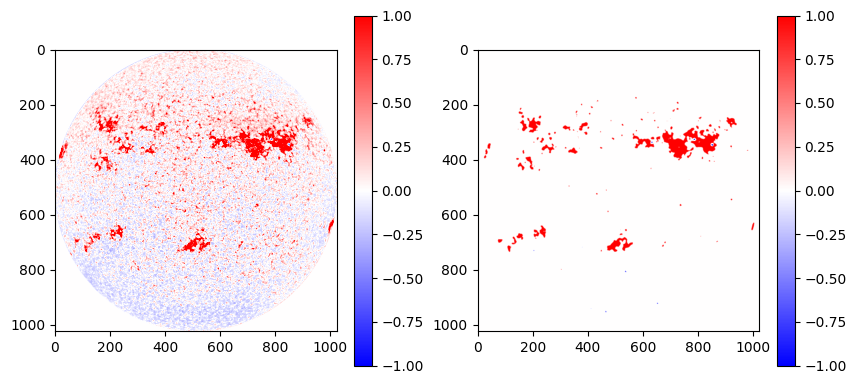

In [ ]:
# Supported values are 'none', 'antialiased', 'nearest', 'bilinear',
# 'bicubic', 'spline16', 'spline36', 'hanning', 'hamming', 'hermite',
# 'kaiser', 'quadric', 'catrom', 'gaussian', 'bessel', 'mitchell',
# 'sinc', 'lanczos', 'blackman'.

#     If *interpolation* is 'none', then no interpolation is performed
# on the Agg, ps, pdf and svg backends. Other backends will fall back
# to 'nearest'. Note that most SVG renderers perform interpolation at
# rendering and that the default interpolation method they implement
# may differ.

# Scale is backwards, positive is cold
# Goal: estimate the area of sunspots
#   get the TSI - Total Solar Irradiance

plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['figure.dpi'] = 100
# plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.grid(False)
plt.imshow(image_array[3100], cmap='bwr', interpolation='bilinear', vmin=-1.0, vmax=1.0)
plt.colorbar()
plt.subplot(2,2,2)
plt.grid(False)
plt.imshow(mask_array[3100], cmap='bwr', interpolation='bilinear', vmin=-1.0, vmax=1.0)
plt.colorbar()
plt.show()

In [ ]:
# Pick x number of images
# For this experiment, we are picking images 3100 to 4099 as training images (1000 images)
# We are going to pick 200 images for test images, 2900 to 3099
train_start = 0
train_end = 4000
test_start = 4000
test_end = 4700

train = image_array[train_start:train_end]
print(f"train shape: {train.shape}")
# train_g = image_array_g[train_start:train_end]
# print(f"train_g size: {len(train_g)}")
# train_b = image_array_b[train_start:train_end]
# print(f"train_b size: {len(train_b)}")
test_images_npa = image_array[test_start:test_end]
print(f"test_images_npa size: {len(test_images_npa)}")

# Pick the corresponding true masks
train_masks_npa = mask_array[train_start:train_end]
test_masks_npa = mask_array[test_start:test_end]
# np.set_printoptions(threshold=sys.maxsize)
print(np.min(mask_array[train_start]))

# area of faculi, area sunspots, avg of whole disk
# focus on area of faculi and sunspots
# undersample study, see how downsamples compare

train shape: (4000, 1024, 1024)
test_images_npa size: 700
-1.0


In [ ]:
# To use image segmentation from tensorflow, we need to convert this dataset
# to tensorflow datasets
# import tensorflow_datasets as tfds
USING_RGB = True

# Set the shape of data
if USING_RGB:
  train_shape = (1024, 1024, 3)
else:
  train_shape = (1024, 1024, 1)
mask_shape = (1024, 1024, 1)

# generator functions
def data_generator_train_image():
  for img in train:
    if USING_RGB:
      rgb = np.stack([img]*3, axis=2)
    else:
      rgb = np.stack([img], axis=2)
    yield rgb

def data_generator_train_mask():
  for mask in train_masks_npa:
    rgb_mask = np.stack([mask], axis=2)
    yield rgb_mask

def data_generator_test():
  for img in train:
    if USING_RGB:
      rgb = np.stack([img]*3, axis=2)
    else:
      rgb = np.stack([img], axis=2)
    yield rgb

def data_generator_test_mask():
  for mask in test_masks_npa:
    rgb_mask = np.stack([mask], axis=2)
    yield rgb_mask

train_ds = tf.data.Dataset.from_generator(
  generator=data_generator_train_image,
  output_types=np.float64,
  output_shapes=train_shape,
)

train_mask_ds = tf.data.Dataset.from_generator(
  generator=data_generator_train_mask,
  output_types=np.int32,
  output_shapes=mask_shape,
)

test_ds = tf.data.Dataset.from_generator(
  generator=data_generator_test,
  output_types=np.float64,
  output_shapes=train_shape,
)

test_mask_ds = tf.data.Dataset.from_generator(
  generator=data_generator_test_mask,
  output_types=np.int32,
  output_shapes=mask_shape,
)

# print(type(train_ds))
# print(type(train_mask_ds))
# print(next(iter(train_ds)))
# print(next(iter(train_mask_ds)))
# train_ds.cardinality()

In [ ]:
dataset_train = tf.data.Dataset.zip(train_ds, train_mask_ds)
dataset_test = tf.data.Dataset.zip(test_ds, test_mask_ds)

In [ ]:
# Try to create a paralell map dataset with both image and mask data

RESIZE_X = 1024
RESIZE_Y = 1024
NORMALIZE = True

def normalize(input_image, input_mask):
  res_img = (input_image + 1)
  res_mask = (input_mask + 1)
  return res_img, res_mask

def load(image, mask):
  if RESIZE_X != 1024:
    input_image = tf.image.resize(image, (RESIZE_X, RESIZE_Y))
    input_mask = tf.image.resize(mask, (RESIZE_X, RESIZE_Y))
  else:
    input_image = image
    input_mask = mask
  if NORMALIZE:
    input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

train_images = dataset_train.map(load, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset_test.map(load, num_parallel_calls=tf.data.AUTOTUNE)

# Settings for modeling
TRAIN_LENGTH = len(train)
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

# print(type(train_images))
# print(next(iter(train_images)))

In [ ]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

In [ ]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-5wj6azuf
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-5wj6azuf
  Resolved https://github.com/tensorflow/examples.git to commit edd2c1fdd607e534087f755186f8c18ce46c8ce4
  Preparing metadata (setup.py) ... done


In [ ]:
# Define the Model

from tensorflow_examples.models.pix2pix import pix2pix

base_model = tf.keras.applications.MobileNetV2(input_shape=[RESIZE_X, RESIZE_Y, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

# Decoder/Upsampler
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[RESIZE_X, RESIZE_Y, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

unet_model = unet_model(output_channels=3)

<ipython-input-18-d06b16514c38>:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(input_shape=[RESIZE_X, RESIZE_Y, 3], include_top=False)


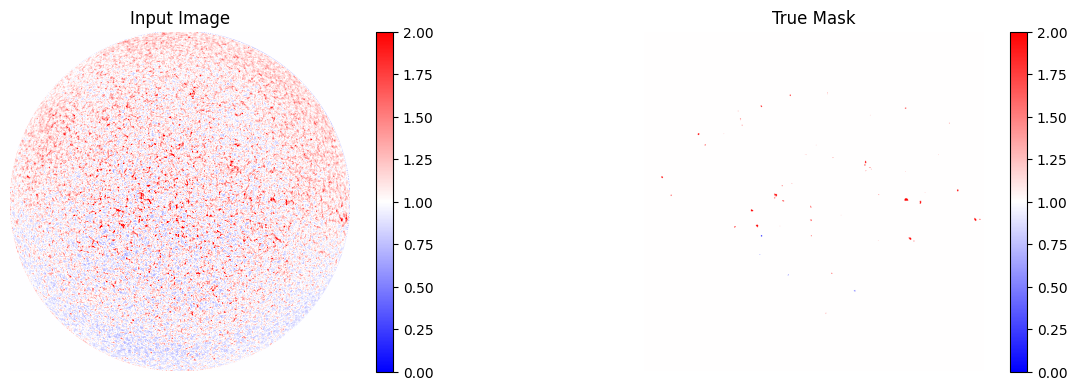

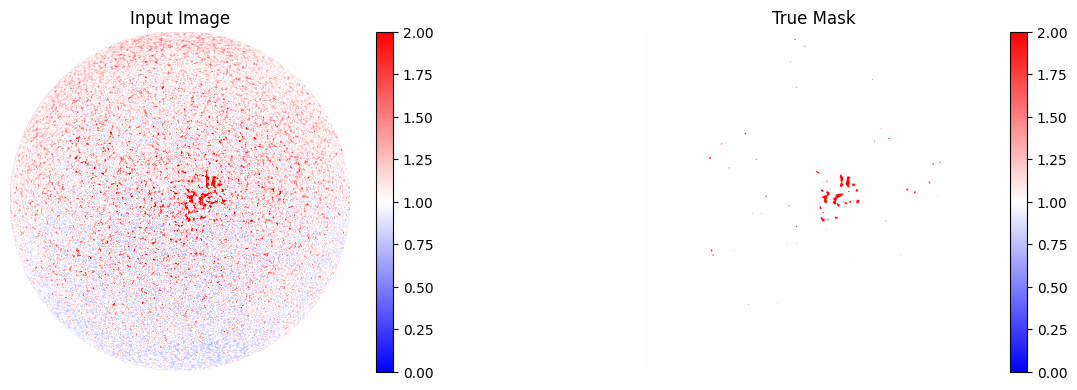

In [ ]:
# Create function to display the image, mask, and predicted mask

def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(3, len(display_list), i+1)
    plt.title(title[i])
    if USING_RGB:
      # unstacked = tf.unstack(display_list[i], axis=2)
      # print(display_list[i][0:5, 0:5, 0])
      # plt.imshow(tf.keras.utils.array_to_img(display_list[i]), cmap='bwr', interpolation='bilinear')
      plt.imshow(display_list[i][:,:,0], cmap='bwr', vmin=0.0, vmax=2.0)
    else:
      plt.imshow(display_list[i], cmap='bwr', interpolation='bilinear', vmin=-1.0, vmax=1.0)
    plt.colorbar()
    plt.axis('off')
  plt.show()

for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

In [ ]:
# Train the Model

OUTPUT_CLASSES = 3

# model = unet_model(output_channels=OUTPUT_CLASSES)
unet_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Optional: Plot the model architecture
# tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=True, dpi=64)

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


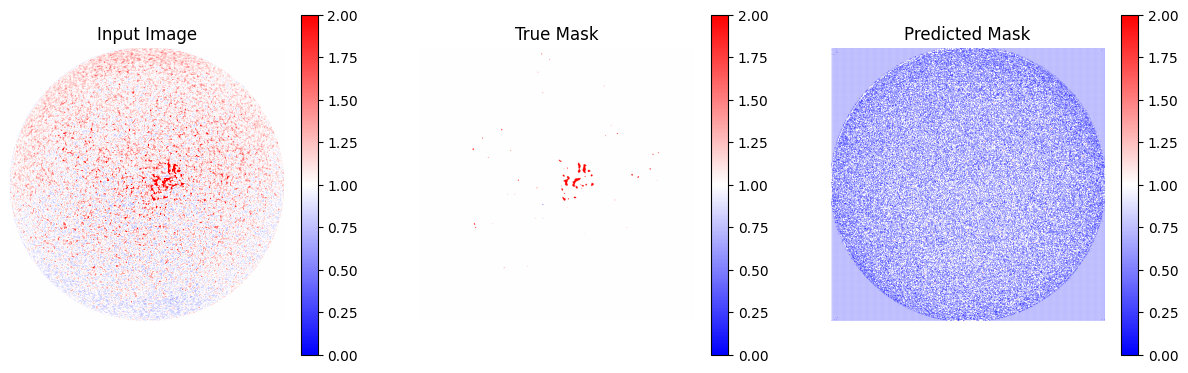

In [ ]:
# Try out the model to check what it predicts before training
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = unet_model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(unet_model.predict(sample_image[tf.newaxis, ...]))])

show_predictions()

In [ ]:
# Callback function to display the prediction as it improves

from IPython.display import clear_output

class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

# Set the epocs


EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = len(test_images_npa)//BATCH_SIZE//VAL_SUBSPLITS

model_history = unet_model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()],
                          verbose=2)

Epoch 1/20


In [ ]:
# Show training and validation loss
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [ ]:
show_predictions(test_batches, 3)

In [ ]:
# Define the Model ( 2nd Method )

# Building Blocks
def double_conv_block(x, n_filters):
    # Conv2D then relu activation
    x = Conv2D(n_filters, 3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
    # Conv2D then relu activation
    x = Conv2D(n_filters, 3, padding='same', activation='relu', kernel_initializer='he_normal')(x)

    return x

def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = MaxPool2D(2)(f)
    p = Dropout(0.3)(p)

    return f, p

def upsample_block(x, conv_features, n_filters):
   # upsample
   x = Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = concatenate([x, conv_features])
   # dropout
   x = Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)
   return x

def build_unet_model():
    # inputs
    inputs = Input(shape=(RESIZE_X,RESIZE_Y,1))
    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)
    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)
    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)
    # outputs
    outputs = Conv2D(3, 1, padding="same", activation = "relu")(u9)
    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
    return unet_model

unet_model = build_unet_model()

In [ ]:
# Saving test text